In [1]:
using Pkg; using Distributed; using Distributions; using DelimitedFiles; using Plots; using Base.Threads;using Random; using LinearAlgebra; gr()

Plots.GRBackend()

In [2]:
nthreads()

1

In [1]:
#Define space :

# Description of an experiment in a cavity
# The experiment here is in free space, uncomment to place yourself in the conditions of this experiment

struct Dimension
    Lx ::Float64  #length of the cavity along x-axis - in m
    Ly ::Float64
    Lz::Float64
    #origin of the x axis placed at the center of the cavity
    Bx ::Float64 #Lx/2 #extreme point along x axis
    By ::Float64
    Bz ::Float64
end

const Lx = 5. *10^(-3) #m
const Ly = 5. *10^(-3) #m
const Lz = 10. *10^(-3) #m

dimension = Dimension(Lx, Ly, Lz, Lx/2., Ly/2., Lz/2.)

#General Physical constants:
struct Physics
    mu0 ::Float64  #T.m/A
    k_B ::Float64 #J/K
    e ::Float64 #C
    a0 ::Float64 #m #Bohr Radius
    c ::Float64 #m/s
    h ::Float64 #m².kg/s
    muB ::Float64 #J.T-1
    R ::Float64 #J.K-1.mol-1#Gas constant
    Na ::Float64 #mol-1 #Avogadro's number
end

physics = Physics(4*pi*10^(-7) , 1.3806504*10^(-23), 1.602176487*10^(-19), 0.52917720859*10^(-10), 299792458, 6.62607004*10^(-34), 9.274009994*10^(-24), 8.3145, 6.02*10^23)        

#Initial Properties of Cesium gaz:

struct Cloud
    P ::Float64 #Pa #Pressure
    V ::Float64 #m^3 #Volume
    T ::Float64 #°K
    n ::Float64 #mol #Quantity of Cesium atoms
    N ::Int64 #Number of Cesium atoms
    
end

P = 1/500/293*10^(-7); #Pa #Pressure 
V = dimension.Lx*dimension.Ly*dimension.Lz; #m^3 #Volume
T = 0.002; #°K #Temperature
n = P*V/(physics.R*T); #mol #Quantity of Cesium atoms
N = round(Int, n*physics.Na) #Number of Cesium atoms

cloud = Cloud(P, V, T, n, N)

#Model Cesium atoms as 4-level atoms:
#Transition Cs |6S(1/2) L = 0, mL = 0> -> Cs |6P(3/2) L=1, mL = -1,0,1>
struct Particle
    m ::Float64  #kg
    wa ::Float64  #rad.s-1 #transition frequency
    γ ::Float64  #Hz #decay rate
    tau ::Float64  #s #lifetime
    vr ::Float64  #m.s-1 #recoil velocity
    wr ::Float64 #Hz #recoil "energy"
    Tr ::Float64  #K #recoil Temperature
    Td ::Float64  #K #doppler Temperature
    d ::Float64  
    Is ::Float64 #W/m^2 #Staturation Intensity for a σ+- light for a Cs |6S(1/2) F = 4, mF = +-4> -> Cs |6P(3/2) F = 5, mF = +-5>
    gL ::Float64 #Electron-orbital g-factor
end

cesium = Particle(2.2*10^(-25), 2*pi*351.72571850*10^(12),2*pi*5.18*10^6, 30.405*10^(-9), 3.5225 * 10^(-3), 2*pi*2.0663*10^3, 198.34 * 10^(-9), 125.61*10^(-6), 2.5886*physics.e*physics.a0, 11.049, 0.99999587)

#Beam properties:

struct Beam
    Dl :: Float64  #m #diameter of the beam at the origin
    δ :: Float64  #s-1 #detuning frequency
    wl :: Float64  #rad.s-1 #laser frequency
    λ :: Float64   #m #laser wavelength
    k :: Float64 #rad.m-1 #laser wave number
    I0 :: Float64  #intensity at 
    E0 :: Float64
    w0 :: Float64 # = Dl/2 #cm 
    zR :: Float64 # = pi*w0^2/λ
    direction_x :: Int64
    direction_y :: Int64
    direction_z :: Int64
    sigma ::Int64
end

w0 = 11/2*10^(-2)
δ = -0.5*cesium.γ
wl = cesium.wa + δ
λ = 2*pi*physics.c/wl
I0 = 0.1*cesium.Is
E0 = 2*I0*physics.c*physics.mu0

  #Beam A1 : sigma - polarized transverse gaussian light propagating in the direction -ex
#maximum intensity reached at the origin  
beam_A1 = Beam(2*w0, δ, wl , λ,  wl/physics.c, 0.1*cesium.Is, 2*I0*physics.c*physics.mu0, w0, pi*w0^2/λ, -1, 0, 0, -1)
  #Beam A2 : sigma - polarized transverse gaussian light propagating in the direction +ex  
#maximum intensity reached at the origin
beam_A2 = Beam(2*w0, δ, wl , λ,  wl/physics.c, 0.1*cesium.Is, 2*I0*physics.c*physics.mu0, w0, pi*w0^2/λ, 1, 0, 0, -1)
  #Beam B1 : sigma - polarized transverse gaussian light propagating in the direction -ey  
#maximum intensity reached at the origin
beam_B1 = Beam(2*w0, δ, wl , λ,  wl/physics.c, 0.1*cesium.Is, 2*I0*physics.c*physics.mu0, w0, pi*w0^2/λ, 0, -1, 0, -1)
  #Beam B2 : sigma - polarized transverse gaussian light propagating in the direction +ey 
#maximum intensity reached at the origin
beam_B2 = Beam(2*w0, δ, wl , λ,  wl/physics.c, 0.1*cesium.Is, 2*I0*physics.c*physics.mu0, w0, pi*w0^2/λ, 0, 1, 0, -1)
  #Beam C1 : sigma + polarized transverse gaussian light propagating in the direction -ez  
#maximum intensity reached at the origin
beam_C1 = Beam(2*w0, δ, wl , λ,  wl/physics.c, 0.1*cesium.Is, 2*I0*physics.c*physics.mu0, w0, pi*w0^2/λ, 0, 0, -1, 1)
  #Beam C2 : sigma + polarized transverse gaussian light propagating in the direction +ez  
#maximum intensity reached at the origin
beam_C2 = Beam(2*w0, δ, wl , λ,  wl/physics.c, 0.1*cesium.Is, 2*I0*physics.c*physics.mu0, w0, pi*w0^2/λ, 0, 0, 1, 1)

beams = Vector{Beam}(undef,6)
beams[1] = beam_A1
beams[2] = beam_A2
beams[3] = beam_B1
beams[4] = beam_B2
beams[5] = beam_C1
beams[6] = beam_C2

#simulation
struct Simulation
    t ::Float64  #s #time of the simulation
    dt ::Float64 ; #time step
    Nt ::Int64 ; # = convert(Int, round(t/dt))#number of iteration
end

const t = 10*10^(-3)
const dt = 0.1/cesium.γ
const Nt = convert(Int, round(t/dt))
simulation = Simulation(t, dt, Nt)

function E2(beam::Beam, x::Float64,y::Float64,z::Float64) #Intensity beam B1
  #Beam B1 : sigma - polarized transverse gaussian light propagating in the direction -ey  
  #maximum intensity reached at the origin
    k_vector = [beam.direction_x; beam.direction_y; beam.direction_z] 
    U = [-1/sqrt(2) 0. 1/sqrt(2); -1im/sqrt(2) 0. -1im/sqrt(2); 0. 1. 0.]
    B_vector = [x;y;-2. *z]
    B_value = norm(B_vector)
    dir = x*beam.direction_x+y*beam.direction_y+z*beam.direction_z
    r2 = x^2*(1. -abs(beam.direction_x))+y^2*(1. -abs(beam.direction_y))+z^2*(1. -abs(beam.direction_z))
    E_vector = (beam.direction_x+beam.direction_y+beam.direction_z)*1. /sqrt(1. +(dir/beam.zR)^2)*exp(-1. *r2/beam.w0^2/(1. +(dir/beam.zR)^2))*exp((beam.direction_x+beam.direction_y+beam.direction_z)*-1im*(beam.k*dir+beam.k*r2*dir/2. /beam.zR^2/(1. +(dir/beam.zR)^2)-atan(dir/beam.zR)))*(abs(beam.direction_y)*[beam.direction_y*beam.sigma*1im,0. ,1.]+abs(beam.direction_x)*[0.,1.,beam.direction_x*beam.sigma*1im]+abs(beam.direction_z)*[1.,beam.direction_z*beam.sigma*1im,0.])/sqrt(2)

   if B_value == 0.
   
      return E_vector
   
   else
      
      normalize!(B_vector)
      v = cross(k_vector, B_vector)
      c = dot(B_vector,k_vector)
      
      if c == -1.
        return U*[-1. 0. 0.; 0. -1. 0.; 0. 0. 1.]*E_vector
   
      else
        v_cross_product_matrix = [0 -v[3] v[2] ; v[3] 0 -v[1]; -v[2] v[1] 0]
        R = UniformScaling(1.) + v_cross_product_matrix + v_cross_product_matrix^2/(1+c)    
        return U*R*E_vector
      end
   end
end

function s(particle::Particle, beam::Beam, x::Float64,y::Float64,z::Float64) #saturation parameter Beam A2
    return abs.(E2(beam,x,y,z)).^2*beam.I0/particle.Is
end

function s2!(particle::Particle, beam::Beam, cloud::Cloud, x::Vector{Float64}, y::Vector{Float64}, z::Vector{Float64}, s_vect::Array{Float64,2}) #saturation parameter Beam A2
    for i =1:cloud.N
        s_vect[i,:] =  abs.(E2(beam,x[i],y[i],z[i])).^2*beam.I0/particle.Is
    end
end

s2! (generic function with 1 method)

In [12]:
print("N = ", cloud.N, "\n")
print("wa = ",cesium.wa,"\n") 
print("δ = ", beam_A1.δ, "\n")
print("wl = ", beam_A1.wl, "\n")
print("λ = ", beam_A1.λ, "\n")
print("k = ", beam_A1.k, "\n")
print("γ = ",cesium.γ, "\n")
print("tau = ", cesium.tau, "\n")
print("Is =", cesium.Is, "\n")
print("Nt = ", simulation.Nt, "\n")
print("dt = ", simulation.dt, "\n")
print("zR = ", beam_A1.zR, "\n")
print(physics.h/2/pi/cesium.m*beam_A1.k)

N = 12
wa = 2.2099578666363832e15
δ = -1.6273449945595128e7
wl = 2.2099578503629332e15
λ = 8.523472820983929e-7
k = 7.371625907823649e6
γ = 3.2546899891190257e7
tau = 3.0405000000000026e-8
Is =11.049
Nt = 3254690
dt = 3.0724892488782887e-9
zR = 11149.584185583273
0.003533594910711686

Let's first plot the initial situation

In [3]:
png(Plots.plot(X,Y,[I0*norm(E2(beam_A1,x,y,0.)) for x in X, y in Y],st=:surface, xlabel = "x(m)", ylabel = "y(m)", zlabel = "|EA1|²(x,y,0)", title = "Intensity of beam A1 over plane z = 0"), "IA1")
png(Plots.plot(X,Y,[I0*norm(E2(beam_A2,x,y,0.)) for x in X, y in Y],st=:surface, xlabel = "x(m)", ylabel = "y(m)", zlabel = "|EA2|²(x,y,0)", title = "Intensity  of beam A2 over plane z = 0"), "IA2")
png(Plots.plot(X,Y,[I0*norm(E2(beam_B1,x,y,0.)) for x in X, y in Y],st=:surface, xlabel = "x(m)", ylabel = "y(m)", zlabel = "|EB1|²(x,y,0)", title = "Intensity  of beam B1 over plane z = 0"), "IB1")
png(Plots.plot(X,Y,[I0*norm(E2(beam_B2,x,y,0.)) for x in X, y in Y],st=:surface, xlabel = "x(m)", ylabel = "y(m)", zlabel = "|EB2|²(x,y,0)", title = "Intensity  of beam B2 over plane z = 0"), "IB2")
png(Plots.plot(Y,Z,[I0*norm(E2(beam_C1,0.,y,z)) for y in Y, z in Z],st=:surface, xlabel = "y(m)", ylabel = "z(m)", zlabel = "|EC1|²(0,y,z)", title = "Intensity  of beam C1 over plane x = 0"), "IC1")
png(Plots.plot(Y,Z,[I0*norm(E2(beam_C2,0.,y,z)) for y in Y, z in Z],st=:surface, xlabel = "y(m)", ylabel = "z(m)", zlabel = "|EC2|²(0,y,z)", title = "Intensity  of beam C2 over plane x = 0"), "IC2")

LoadError: UndefVarError: norm not defined

In [6]:
#Let's plot the intensities of each beam over the space
X = range(-dimension.Bx, stop = dimension.Bx, length = 1000)
Y = range(-dimension.By, stop = dimension.By, length = 1000)
Z = range(-dimension.Bz, stop = dimension.Bz, length = 1000)
png(Plots.plot(X,Y,[s(cesium, beam_A1, x, y, 0.)[1] for x in X, y in Y],st=:surface, xlabel = "x(m)", ylabel = "y(m)", zlabel = "sA1_+(x,y,0)", title = "σ- part of the saturation rate for beam A1 over plane z = 0"), "sA1+")
png(Plots.plot(X,Y,[s(cesium, beam_A1, x, y, 0.)[2] for x in X, y in Y],st=:surface, xlabel = "x(m)", ylabel = "y(m)", zlabel = "sA1_0(x,y,0)", title = "π part of the saturation rate for beam A1 over plane z = 0"), "sA10")
png(Plots.plot(X,Y,[s(cesium, beam_A1, x,y,0.)[3] for x in X, y in Y],st=:surface, xlabel = "x(m)", ylabel = "y(m)", zlabel = "sA1_-(x,y,0)", title = "σ+ part of the saturation rate for beam A1 over plane z = 0"), "sA1-")


In [31]:
#Let's plot the B field in the plane x = 0
Y = range(-dimension.By, stop = dimension.By, length = 20)
Z = range(-dimension.Bz, stop = dimension.Bz, length = 20)
png(Plots.quiver(reshape([y for y in Y, z in Z],400), reshape([z for y in Y, z in Z],400),quiver=(1/20*reshape([y for y in Y, z in Z], 400), 1/20*reshape([-2*z for y in Y, z in Z], 400)), c=:inferno, xlabel = "y(m)", ylabel = "z(m)", title = "B field over plane x = 0"), "Bfield")

Let's now go into the simulation

In [13]:
mutable struct System{A<:AbstractVector}
    position_x ::A 
    position_y ::A
    position_z ::A
    speed_x ::A
    speed_y ::A
    speed_z ::A
end

#Position vectors are taken randomly following a uniform distribution over space
particles_x = rand(range(-dimension.Bx, stop = dimension.Bx, length = 10000), cloud.N); 
particles_y = rand(range(-dimension.By, stop = dimension.By, length = 10000), cloud.N);
particles_z = rand(range(-dimension.Bz, stop = dimension.Bz, length = 10000), cloud.N);

#If you want to initialize by hand
#particles_x = [-2*dimension.Bx, -dimension.Bx, -dimension.Bx/2, -dimension.Bx /4, 0, dimension.Bx/8, dimension.Bx/4, dimension.Bx/2, dimension.Bx, 2*dimension.Bx]
#particles_y = zeros(cloud.N)
#particles_z = zeros(cloud.N)

#Velocity vectors are taken randomly following a Maxwell-Boltzmann distribution over space
#Equivalent : Each component of each velocity vector is taken randomly following a Gaussian distribution over space

d = Normal() #Normal distribution
sigma = sqrt(physics.k_B*cloud.T/cesium.m) #Variance
particles_vx = sigma*rand(d, cloud.N);
particles_vy = sigma*rand(d, cloud.N);
particles_vz = sigma*rand(d, cloud.N);

#Arbitrary Velocity vectors
#particles_vx = -10.0*ones(cloud.N)
#particles_vy = zeros(cloud.N)
#particles_vz = zeros(cloud.N)

system = System(particles_x, particles_y, particles_z, particles_vx, particles_vy, particles_vz)

System{Array{Float64,1}}([0.0001352635263526353, 0.0022939793979397946, -0.001960946094609461, 0.0010753575357535755, 0.0021844684468446847, -0.0014228922892289232, -0.0014033903390339036, -0.0017709270927092713, -0.0009703470347034706, -0.002092459245924593, 0.0013008800880088011, -0.0009063406340634065], [0.0016259125912591263, 0.0007563256325632565, 0.0014688968896889691, -0.0016129112911291133, -0.0009688468846884691, 0.0021994699469947, 0.0019009400940094012, 0.0022439743974397445, 0.00043879387938793886, 0.0023609860986098614, 0.0016024102410241027, 0.00035528552855285534], [0.0012276227622762279, 0.0006025602560256027, -0.0007815781578157817, 0.00131963196319632, 0.0032938293829382946, -0.0025717571757175725, -0.002573757375737574, 0.0037048704870487055, -0.002272727272727273, 0.0031468146814681475, -0.001323632363236324, -0.0027367736773677375], [0.045298895466555494, 0.03180779319364623, 0.6661395346917816, 0.03336451095967723, -0.19603308004606246, -0.4424341717202578, 0.2720

In [14]:
function mean_speed_squared(cloud::Cloud, system::System)
    
    #returns the instantaneous temperature of the system T= m/(degree_of_freedom*N*k_B)*sum_{i=1,N}(v_i^2) 
    #Here we have 1 degree of freedom

    return 1/cloud.N*sum(system.speed_x.^2 .+ system.speed_y.^2 .+ system.speed_z.^2 )
end

function mean(cloud::Cloud, system::System)

  #compute the mean of the system

  return [sum(system.speed_x), sum(system.speed_y), sum(system.speed_z)]/cloud.N
  
end 

mean (generic function with 1 method)

In [15]:
mean_speed_squared(cloud, system)

0.46933078436968667

In [16]:
mean(cloud, system)

3-element Array{Float64,1}:
  0.14116954509500126
 -0.02481589861817728
  0.09657851788176995

In [17]:
function normB(x::Float64,y::Float64,z::Float64)
    return sqrt(x^2+y^2+4*z^2)
end

function step!(dimension::Dimension, physics::Physics, particle::Particle, cloud::Cloud, beams::Vector{Beam}, simulation::Simulation, system::System, system_over_time ::Vector{System})
        
    for j = 2 : simulation.Nt #at each time step
        
        s_vect = Array{Float64,2}(undef,cloud.N,3)
        rva = Array{Float64,2}(undef,cloud.N,3)
        z_shift = Array{Float64,1}(undef, cloud.N)

        for idbeam = 1:6
            
            s2!(particle, beams[idbeam], cloud, system.position_x, system.position_y, system.position_z, s_vect)
            z_shift = particle.gL .* physics.muB .* normB.(system.position_x,system.position_y,system.position_z)./physics.h .* 2 .*pi
            rva = rand(Float64, cloud.N, 3)
            rho_ee = Array{Float64,1}(undef, cloud.N)
            theta = Array{Float64,1}(undef, cloud.N)
            phi = Array{Float64,1}(undef, cloud.N)
            scatter_event = Array{Float64,1}(undef, cloud.N)
            
            for pol = 1:3
                
                rho_ee .= simulation.dt .* particle.γ .* s_vect[:,pol] ./ 2 ./ (1 .+ s_vect[:,pol] .+ (2 .*(beams[idbeam].δ .- beams[idbeam].k .* (beams[idbeam].direction_x .* system.speed_x .+ beams[idbeam].direction_y .* system.speed_y .+ beams[idbeam].direction_z .* system.speed_z) .+ (pol.-2).*z_shift) ./ particle.γ) .^2) #laser1
            
                scatter_event .= physics.h ./ 2. ./ pi ./ particle.m .* beams[idbeam].k .* (rva[:,pol] .< rho_ee)
                theta = 2*pi*rand(Float64, cloud.N) #random inclination of the emitted photon
                phi = 2*pi*rand(Float64, cloud.N) #random azimuth of the emitted photon
            
                system.speed_x .= system.speed_x .+  scatter_event .*(beams[idbeam].direction_x .+ sin.(theta).*cos.(phi)) 
                system.speed_y .= system.speed_y .+  scatter_event .*(beams[idbeam].direction_y .+ sin.(theta).*sin.(phi)) 
                system.speed_z .= system.speed_z .+  scatter_event .*(beams[idbeam].direction_z .+ cos.(theta))
        
            end
        
        end
        system.position_x .= system.position_x .+ system.speed_x .*simulation.dt
        system.position_y .= system.position_y .+ system.speed_y .*simulation.dt
        system.position_z .= system.position_z .+ system.speed_z .*simulation.dt
        system_over_time[j] = deepcopy(system)
    end
end

function experiment(dimension::Dimension, physics::Physics, particle::Particle, cloud::Cloud, beams::Vector{Beam}, simulation::Simulation, system::System)

    system_over_time = Vector{System}(undef,simulation.Nt)
    
    system_over_time[1] = deepcopy(system)
    
    step!(dimension, physics, particle, cloud, beams, simulation, system, system_over_time)
    
    return system_over_time
end

experiment (generic function with 1 method)

In [18]:
@time system_over_time = experiment(dimension, physics, cesium, cloud, beams, simulation, system)

6894.815159 seconds (20.74 G allocations: 1.392 TiB, 7.61% gc time)


3254690-element Array{System,1}:
 System{Array{Float64,1}}([0.0001352635263526353, 0.0022939793979397946, -0.001960946094609461, 0.0010753575357535755, 0.0021844684468446847, -0.0014228922892289232, -0.0014033903390339036, -0.0017709270927092713, -0.0009703470347034706, -0.002092459245924593, 0.0013008800880088011, -0.0009063406340634065], [0.0016259125912591263, 0.0007563256325632565, 0.0014688968896889691, -0.0016129112911291133, -0.0009688468846884691, 0.0021994699469947, 0.0019009400940094012, 0.0022439743974397445, 0.00043879387938793886, 0.0023609860986098614, 0.0016024102410241027, 0.00035528552855285534], [0.0012276227622762279, 0.0006025602560256027, -0.0007815781578157817, 0.00131963196319632, 0.0032938293829382946, -0.0025717571757175725, -0.002573757375737574, 0.0037048704870487055, -0.002272727272727273, 0.0031468146814681475, -0.001323632363236324, -0.0027367736773677375], [0.045298895466555494, 0.03180779319364623, 0.6661395346917816, 0.03336451095967723, -0.196033080046

In [19]:
mean_speed_squared_over_time = [mean_speed_squared(cloud, system_over_time[i]) for i=1:simulation.Nt];

In [20]:
mean_over_time = [mean(cloud, system_over_time[i]) for i=1:simulation.Nt];

In [21]:
variance_over_time = [mean_speed_squared_over_time[i] - norm(mean_over_time[i]) for i=1:simulation.Nt]

3254690-element Array{Float64,1}:
  0.29649537305939816
  0.29649537305939816
  0.29649537305939816
  0.29649537305939816
  0.29649537305939816
  0.29649537305939816
  0.29649537305939816
  0.29649537305939816
  0.29649537305939816
  0.29649537305939816
  0.29649537305939816
  0.29649537305939816
  0.29649537305939816
  ⋮
 -0.02771506441857763
 -0.02771506441857763
 -0.02771506441857763
 -0.02771506441857763
 -0.02771506441857763
 -0.02771506441857763
 -0.02771506441857763
 -0.02771506441857763
 -0.02771506441857763
 -0.02771506441857763
 -0.02771506441857763
 -0.02771506441857763

In [22]:
time = [k*simulation.dt for k=1:simulation.Nt]

3254690-element Array{Float64,1}:
 3.0724892488782887e-9
 6.144978497756577e-9
 9.217467746634866e-9
 1.2289956995513155e-8
 1.5362446244391444e-8
 1.843493549326973e-8
 2.1507424742148022e-8
 2.457991399102631e-8
 2.7652403239904597e-8
 3.072489248878289e-8
 3.3797381737661175e-8
 3.686987098653946e-8
 3.994236023541775e-8
 ⋮
 0.009999966236049939
 0.009999969308539188
 0.009999972381028437
 0.009999975453517686
 0.009999978526006936
 0.009999981598496185
 0.009999984670985434
 0.009999987743474681
 0.00999999081596393
 0.00999999388845318
 0.009999996960942429
 0.010000000033431678

In [36]:
#We are interested in the mean squared speed over time
png(Plots.plot(time, mean_speed_squared_over_time, title = "Mean of the squared speed over time", xlabel = "t (s)", ylabel = "<v²>(t) (m.s-1)"), "Squared_speed_3D6lasers_MOT_0.002") 

In [25]:
#We are interested in the mean over time

png(Plots.plot(time, [mean[1] for mean in mean_over_time], title = "Mean speed along x absciss over time", xlabel = "t (s)", ylabel = "<vx>(t) (m/s)"), "Meanx_3D6lasers_MOT_0.002")
png(Plots.plot(time, [mean[2] for mean in mean_over_time], title = "Mean speed along y absciss over time", xlabel = "t (s)", ylabel = "<vy>(t) (m/s)"), "Meany_3D6lasers_MOT_0.002")
png(Plots.plot(time, [mean[3] for mean in mean_over_time], title = "Mean speed along z absciss over time", xlabel = "t (s)", ylabel = "<vz>(t) (m/s)"), "Meanz_3D6lasers_MOT_0.002")

In [26]:
#We are interested in the variance over time
png(Plots.plot(time, variance_over_time, title = "Variance over time", xlabel = "t (s)", ylabel = "<v²(t)>-<v(t)>² (m/s)²"), "Variance_3D6lasers_MOT_0.002")

In [27]:
file_data = string("simulation_data_0.002.txt")#stores the data of the particles over time
touch(file_data)

"simulation_data_0.002.txt"

In [39]:
1/3*0.015*cesium.m/physics.k_B

7.967259488716334e-5

In [37]:
#We are interested in the minimum speed reached by the system
min_v = minimum(mean_speed_squared_over_time)
data1 = string("minimum speed reached : ",min_v," m.s-1")
print(data1, "\n")

#add the data to the file
open(file_data, "a") do io
       write(io, data1)
end

minimum speed reached : 0.015549715888370761 m.s-1


50

In [29]:
#We are interested in the time it takes to get this speed
min_v_reached = findfirst(isequal(min_v),mean_speed_squared_over_time)
data2 = string("minimum speed is reached after ", min_v_reached*dt, " s (that is, after ", min_v_reached," iteration)")
print(data2,"\n")
open(file_data, "a") do io
       write(io, data2)
end

minimum speed is reached after 0.005963382093190875 s (that is, after 1940896 iteration)

88

In [30]:
#We are interested in the maximum variance reached
data3 = string("maximum variance reached : ", maximum(variance_over_time), " m2.s-2")
print(data3)
open(file_data, "a") do io
       write(io, data3)
end

maximum variance reached : 0.29974348182545113 m2.s-2

53

In [31]:
#We are interested in the dynamics of the atoms over time
for i = 1:N
    pltvx = Plots.plot(time,[system_over_time[j].speed_x[i] for j in 1:Nt], title = "Projected speed on x over time", xlabel = "t (s)", ylabel = "vx(t) (m/s)")  
    pltvy = Plots.plot(time,[system_over_time[j].speed_y[i] for j in 1:Nt], title = "Projected speed on y over time", xlabel = "t (s)", ylabel = "vy(t) (m/s)")
    pltvz = Plots.plot(time,[system_over_time[j].speed_z[i] for j in 1:Nt], title = "Projected speed on z over time", xlabel = "t (s)", ylabel = "vz(t) (m/s)")  

    pltx = Plots.plot(time,[system_over_time[j].position_x[i] for j in 1:Nt], title = "Position x over time", xlabel = "t (s)", ylabel = "x(t) (m)")  
    plty = Plots.plot(time,[system_over_time[j].position_y[i] for j in 1:Nt], title = "Position y over time", xlabel = "t (s)", ylabel = "y(t) (m)")
    pltz = Plots.plot(time,[system_over_time[j].position_z[i] for j in 1:Nt], title = "Position z over time", xlabel = "t (s)", ylabel = "z(t) (m)")  

    #show the two graphics on the same image
    png(Plots.plot(pltvx, pltx, layout = (2,1)), string("movement_x_part_",string(i),"_3D6lasers_MOT_0.002"))
    png(Plots.plot(pltvy, plty, layout = (2,1)), string("movement_y_part_",string(i),"_3D6lasers_MOT_0.002"))
    png(Plots.plot(pltvz, pltz, layout = (2,1)), string("movement_z_part_",string(i),"_3D6lasers_MOT_0.002"))  
end

In [32]:
v2max = [system_over_time[i].speed_x.^2+system_over_time[i].speed_y.^2+system_over_time[i].speed_z.^2 for i=1:simulation.Nt]

3254690-element Array{Array{Float64,1},1}:
 [0.9797383269617751, 0.10395343980510056, 0.7382150086343535, 0.04679749095724611, 0.1321481883816174, 0.3794442719589345, 0.1997657941607994, 0.8263757509202332, 0.8876320350162482, 0.2334397560831511, 0.9087406218991931, 0.1957187276575877]
 [0.9797383269617751, 0.10395343980510056, 0.7382150086343535, 0.04679749095724611, 0.1321481883816174, 0.3794442719589345, 0.1997657941607994, 0.8263757509202332, 0.8876320350162482, 0.2334397560831511, 0.9087406218991931, 0.1957187276575877]
 [0.9797383269617751, 0.10395343980510056, 0.7382150086343535, 0.04679749095724611, 0.1321481883816174, 0.3794442719589345, 0.1997657941607994, 0.8263757509202332, 0.8876320350162482, 0.2334397560831511, 0.9087406218991931, 0.1957187276575877]
 [0.9797383269617751, 0.10395343980510056, 0.7382150086343535, 0.04679749095724611, 0.1321481883816174, 0.3794442719589345, 0.1997657941607994, 0.8263757509202332, 0.8876320350162482, 0.2334397560831511, 0.9087406218991931, 0

┌ Info: Saved animation to 
│   fn = D:\Users\Antoine\Documents\copenhague-1\togit\togit\Laser cooling\3D\3D6Lasers\MOT\4-level atom\simulation_3D6Lasers_MOT_0.002.gif
└ @ Plots D:\Users\Antoine\.julia\packages\Plots\lmp2A\src\animation.jl:104


Plots.AnimatedGif("D:\\Users\\Antoine\\Documents\\copenhague-1\\togit\\togit\\Laser cooling\\3D\\3D6Lasers\\MOT\\4-level atom\\simulation_3D6Lasers_MOT_0.002.gif")
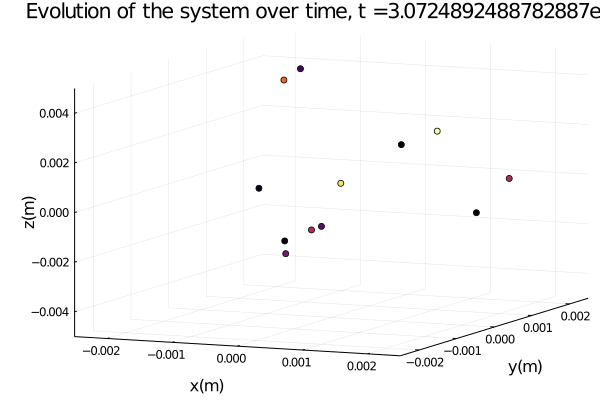

In [33]:
anim = Animation()

for j in range(1, step=1000000, stop = simulation.Nt+1) 

    X = range(-dimension.Bx, stop = dimension.Bx, length = 100)
    Y = range(-dimension.By, stop = dimension.By, length = 100)
    Z = range(-dimension.Bz, stop = dimension.Bz, length = 100)
    
    #Plots.plot(X,range(-w0, stop = w0, length = 100),[sqrt(w0^2-y^2) for x in X, y in range(-w0, stop = w0, length = 100)],st=:surface, c=:blues, opacity = 0.3,  leg = false, camera = (-30,30))
    #Plots.plot(X,range(-w0, stop = w0, length = 100),[-sqrt(w0^2-y^2) for x in X, y in range(-w0, stop = w0, length = 100)],st=:surface, c = :blues, opacity = 0.3, leg = false, camera = (-30,30))
    Plots.scatter(system_over_time[j].position_x,system_over_time[j].position_y,system_over_time[j].position_z, title = string("Evolution of the system over time, t =", j*dt, " s"), xlabel = "x(m)", ylabel = "y(m)", zlabel = "z(m)", xlim = (-dimension.Bx,dimension.Bx), ylim = (-dimension.By,dimension.By), zlim = (-dimension.Bz,dimension.Bz), marker_z = 1 ./ v2max[j] .* (system_over_time[j].position_x.^2 .+ system_over_time[j].position_y.^2 .+ system_over_time[j].position_z.^2), leg = false)
    #Plots.plot(range(-w0, stop = w0, length = 100),Y,[sqrt(w0^2-x^2) for x in range(-w0, stop = w0, length = 100), y in Y],st=:surface, c=:blues, opacity = 0.3, leg = false, camera = (-30,30) )
    #Plots.plot(range(-w0, stop = w0, length = 100),Y,[-sqrt(w0^2-x^2) for x in range(-w0, stop = w0, length = 100), y in Y],st=:surface, c=:blues, opacity = 0.3, leg = false, camera = (-30,30))
    Plots.frame(anim)
end
gif(anim, "simulation_3D6Lasers_MOT_0.002.gif", fps=1)

┌ Info: Saved animation to 
│   fn = D:\Users\Antoine\Documents\copenhague-1\togit\togit\Laser cooling\3D\3D6Lasers\MOT\4-level atom\speed_distribution_3D6lasers_0.002.gif
└ @ Plots D:\Users\Antoine\.julia\packages\Plots\lmp2A\src\animation.jl:104


Plots.AnimatedGif("D:\\Users\\Antoine\\Documents\\copenhague-1\\togit\\togit\\Laser cooling\\3D\\3D6Lasers\\MOT\\4-level atom\\speed_distribution_3D6lasers_0.002.gif")
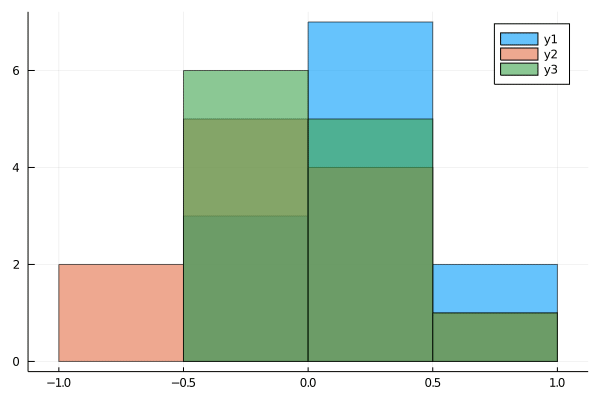

In [34]:
#distribution of speed
anim = Animation()

for k in range(1, step=10000, stop=simulation.Nt+1)
    #plot(xlim = (-Bx, Bx),ylim = (-1, 1))    
    Plots.histogram([system_over_time[k].speed_x system_over_time[k].speed_y system_over_time[k].speed_z],opacity = 0.6)
    Plots.frame(anim)
end
gif(anim, "speed_distribution_3D6lasers_0.002.gif", fps=1)

In [35]:
for i =1:cloud.N
    plt = plot3d(
    1,
    xlim = (-dimension.Bx, dimension.Bx),
    ylim = (-dimension.By, dimension.By),
    zlim = (-dimension.Bz, dimension.Bz),
    title = string("Trajectory of particle", string(i)),
    xlabel = "x (m)",
    ylabel = "y (m)",
    zlabel = "z (m)",
    marker = 2)
    for j in range(1, step=10000, stop=simulation.Nt+1)
        push!(plt, system_over_time[j].position_x[i] ,system_over_time[j].position_y[i],system_over_time[j].position_z[i])
    end
    png(plt, string("traj_",string(i),"_3D6lasers_MOT_0.002"))
end
# build an animated gif by pushing new points to the plot, saving every 10th frame

After each simulation, we add the simulated atoms to a storage file

In [ ]:
#file storing the position
file_position = string("position_T_",T,".txt")#stores the position of the particles over time
touch(file_position)

#file storing the speed
file_speed = string("speed_T_",T,".txt") #stores the position of the particles over time
touch(file_speed) #create the file if it does not exist

"speed_T_1.txt"

In [ ]:
#add the new positions to the file
open(file_position, "a") do io
       writedlm(io, position_over_time)
       end
       
#add the new speeds to the file
open(file_speed, "a") do io
       writedlm(io, speed_over_time)
       end